# 프로젝트 : CAM을 만들고 평가해보자

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [3]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'],[224,224])
    input['image'] = tf.cast(image,tf.float32)/ 255.
    return input['image'],input['label']

In [4]:
num_classes = ds_info.features["label"].num_classes

base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)

x = base_model.output
preds = keras.layers.Dense(num_classes,activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [5]:
cam_model_path = '/content/drive/MyDrive/node/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [6]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

## 1. CAM 구현하기

In [7]:
def generate_cam(model,item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    # input에 대한 output을 CAM과 predict 두개를 받음
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

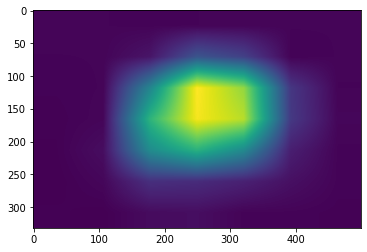

In [8]:
item = get_one(ds_test)
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [9]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

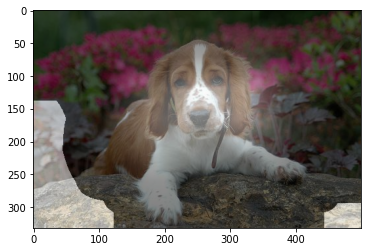

In [10]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 2. Grad-CAM 구현하기

In [11]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]
        
    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

Grad-CAM은 layer별로 Activation map을 얻을 수 있으니 모두 확인해봅니다.

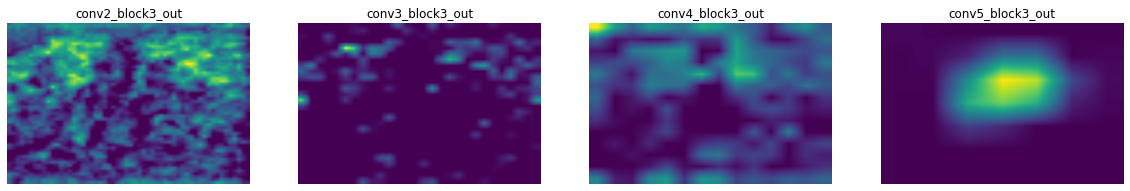

In [12]:
plt.figure(figsize=(20,20))
for i in range(2,6):
    plt.subplot(1,4,i-1)
    name = 'conv'+str(i)+'_block3_out'
    grad_cam_image = generate_grad_cam(cam_model, name, item)
    plt.title(name)
    plt.imshow(grad_cam_image)
    plt.axis('off')

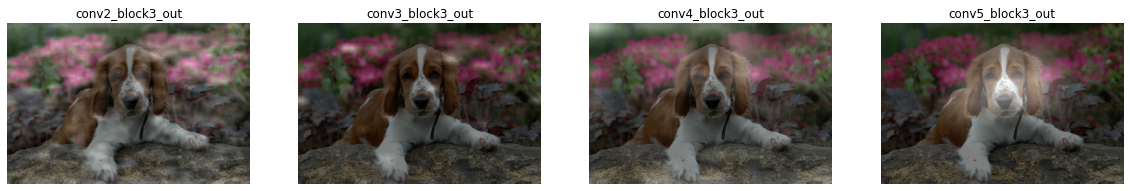

In [13]:
plt.figure(figsize=(20,20))
for i in range(2,6):
    plt.subplot(1,4,i-1)
    name = 'conv'+str(i)+'_block3_out'
    cam_image = generate_grad_cam(cam_model, name, item)
    origin_image = item['image'].astype(np.uint8)
    cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
    blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
    plt.title(name)
    plt.imshow(blended_image)
    plt.axis('off')

## 3. 바운딩 박스 구하기

In [14]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

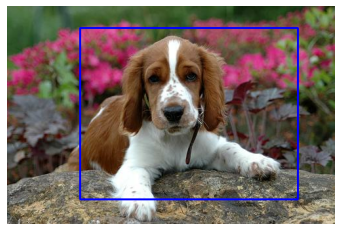

In [15]:
cam_image = generate_cam(cam_model, item)
rect = get_bbox(cam_image)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.axis('off')
plt.show()

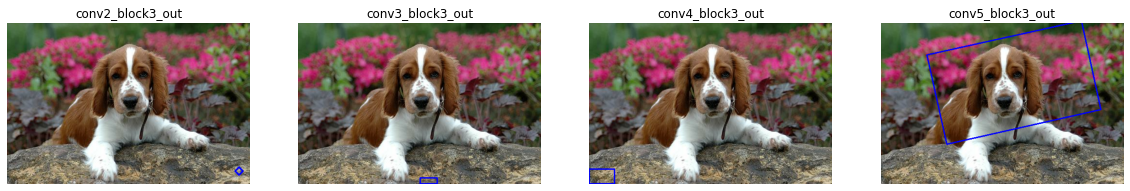

In [16]:
plt.figure(figsize=(20,20))
for i in range(2,6):
    plt.subplot(1,4,i-1)
    name = 'conv'+str(i)+'_block3_out'
    cam_image = generate_grad_cam(cam_model, name, item)
    rect = get_bbox(cam_image,0.09)
    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    plt.title(name)
    plt.imshow(image)
    plt.axis('off')

* 다른 이미지의 경우 이전 레이어의 Grad-CAM이 윤곽을 잘 잡아내는 모습을 보였으나 Activation이 너무 중구난방이라 bbox를 찾는건 좀 더 생각을 좀 해봐야할듯..

## 4. IoU 구하기

In [17]:
# rect 좌표를 이미지의 상대죄표로 바꿔주며 정답 bbox와 표현방식을 맞춰줍니다.
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [18]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

정답 bbox도 시각화해 살펴보기 위해 상대좌표 기반으로 bbox를 그릴 함수를 정의합니다.

In [19]:
def draw_bboxs(detection, im,pred=False):
    im = copy.deepcopy(im)
    
    color = (0,0,255) if pred else (255,0,0)
    x1, y1,w_box, h_box = detection
    ymin,xmin,ymax, xmax=y1, x1, y1 + h_box, x1 + w_box
    imageWidth=im.shape[0]
    imageHeight= im.shape[1]
    (left, right, top, bottom) = map(int,(xmin * imageWidth, xmax * imageWidth,
                                      ymin * imageHeight, ymax * imageHeight))
        
    im = cv2.rectangle(im,(left,top),(right,bottom),color,3)
        
    return im

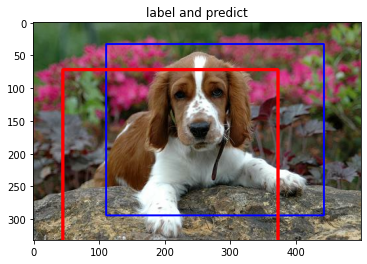

CAM의 IoU :  0.6983858334151163


In [20]:
cam_image = generate_cam(cam_model, item)
rect = get_bbox(cam_image)
pred_bbox = rect_to_minmax(rect, item['image'])
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
image = draw_bboxs(item['objects']['bbox'][0],image)
plt.title('label and predict')
plt.imshow(image)
plt.show()
print("CAM의 IoU : ",get_iou(pred_bbox, item['objects']['bbox'][0]))

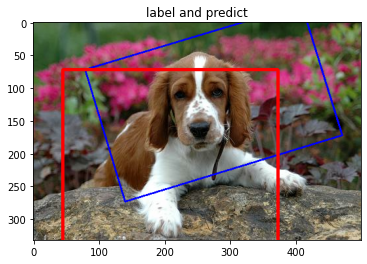

Grad-CAM의 IoU :  0.553156846572964


In [22]:
cam_image = generate_grad_cam(cam_model,'conv5_block3_out' ,item)
rect = get_bbox(cam_image)
pred_bbox = rect_to_minmax(rect, item['image'])
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
image = draw_bboxs(item['objects']['bbox'][0],image)
plt.title('label and predict')
plt.imshow(image)
plt.show()
print("Grad-CAM의 IoU : ",get_iou(pred_bbox, item['objects']['bbox'][0]))